### Step 1. Install Necessary Libraries

In [49]:
# pip install gensim pyLDAvis

### Step 2. Load the CSV File

In [51]:
import pandas as pd

# Load the cleaned text file
df = pd.read_csv("/Users/kaiyang/Desktop/processed_news_data.csv")

# Check the first few rows
print(df.head())

                                               title  \
0  For some Latinos, ‘prosperity gospel’ led them...   
1                    How the GOP is on Self-Destruct   
2     Kamala's Been On A Drinking Binge Since Losing   
3                                        The Victory   
4                 It Must Really Suck For You People   

                                                 url replies views  \
0  https://debatepolitics.com/threads/for-some-la...      48    2K   
1  https://debatepolitics.com/threads/how-the-gop...       2   174   
2  https://debatepolitics.com/threads/kamalas-bee...     187    2K   
3  https://debatepolitics.com/threads/the-victory...     182    2K   
4  https://debatepolitics.com/threads/it-must-rea...     290    2K   

                         cleaned_title  sentiment  
0   latino prosperity gospel led trump        0.0  
1                     gop selfdestruct        0.0  
2  kamalas drinking binge since losing        0.0  
3                              vic

### Step 3. Preprocess the Text for LDA

In [60]:
from nltk.tokenize import word_tokenize

# Function to convert cleaned text into tokenized format (list of words)
def tokenize_text(text):
    if isinstance(text, str):  # Check if the text is a string
        tokens = word_tokenize(text)
    else:
        tokens = []  # If not a string (i.e., NaN or float), return an empty list
    return tokens

# Convert cleaned text (string) to tokenized text (list of words)
df['tokenized_title'] = df['cleaned_title'].apply(tokenize_text)

# Check the first few rows
df[['title', 'cleaned_title', 'tokenized_title']].head()

,title,cleaned_title,tokenized_title
0,"For some Latinos, ‘prosperity gospel’ led them...",latino prosperity gospel led trump,"[latino, prosperity, gospel, led, trump]"
1,How the GOP is on Self-Destruct,gop selfdestruct,"[gop, selfdestruct]"
2,Kamala's Been On A Drinking Binge Since Losing,kamalas drinking binge since losing,"[kamalas, drinking, binge, since, losing]"
3,The Victory,victory,[victory]
4,It Must Really Suck For You People,must really suck people,"[must, really, suck, people]"


In [64]:
import gensim
from gensim import corpora

# Create a dictionary (word -> id mapping)
dictionary = corpora.Dictionary(df["tokenized_title"])

# Convert tokenized documents into a bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in df["tokenized_title"]]

# Print an example
print("Sample Bag-of-Words:", corpus[:1])

Sample Bag-of-Words: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


### Step 4. Finding the best number of topics

Num Topics: 2, Coherence Score: 0.37674245224350056
Num Topics: 4, Coherence Score: 0.4202394612656911
Num Topics: 6, Coherence Score: 0.4627677453015783
Num Topics: 8, Coherence Score: 0.4552088181428377
Num Topics: 10, Coherence Score: 0.4719044578097136
Num Topics: 12, Coherence Score: 0.46789534360781576
Num Topics: 14, Coherence Score: 0.4815217174901823
Num Topics: 16, Coherence Score: 0.4958499857394938
Num Topics: 18, Coherence Score: 0.4768736874934759


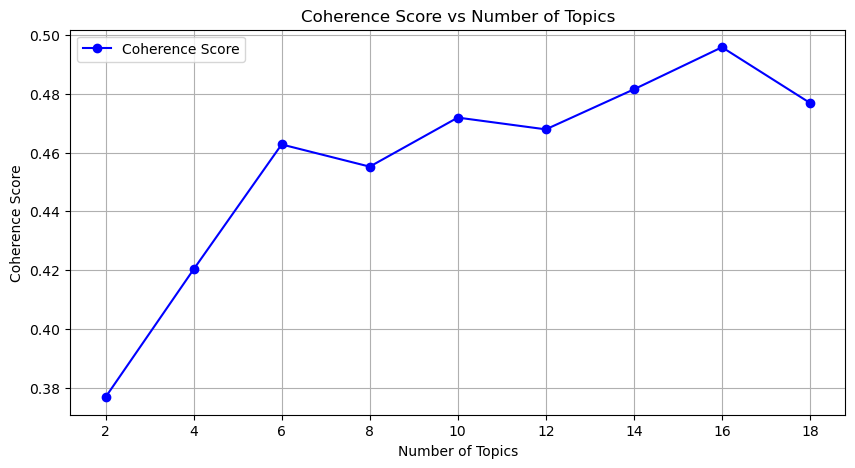

In [79]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel

def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    """
    Compute coherence scores for different numbers of topics.
    """
    coherence_values = []
    topic_numbers = list(range(start, limit, step))
    
    for num_topics in topic_numbers:
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        print(f'Num Topics: {num_topics}, Coherence Score: {coherence_values[-1]}')
    
    return topic_numbers, coherence_values

# Define the range of topics to test
start, limit, step = 2, 20, 2  # Test from 2 to 20 topics

# Compute coherence scores
topic_numbers, coherence_values = compute_coherence_values(dictionary, corpus, df["tokenized_title"], start, limit, step)

# Plot the coherence scores
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_values, marker='o', linestyle='-', color='b', label="Coherence Score")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.legend()
plt.grid()
plt.show()

### Step 5. Train the LDA Model with best numbers 

In [81]:
# Set the number of topics
num_topics = 6

# Train the LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,  # Number of training iterations
    random_state=42
)

# Print the topics
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx + 1}: {topic}")

Topic 1: 0.070*"trump" + 0.019*"harris" + 0.016*"election" + 0.009*"say" + 0.008*"voter" + 0.007*"rally" + 0.007*"state" + 0.006*"win" + 0.006*"presidential" + 0.006*"campaign"
Topic 2: 0.031*"trump" + 0.026*"harris" + 0.014*"election" + 0.010*"president" + 0.008*"day" + 0.008*"kamala_harris" + 0.007*"issue" + 0.007*"debate" + 0.006*"news" + 0.006*"kamala"
Topic 3: 0.047*"trump" + 0.020*"harris" + 0.011*"kamala_harris" + 0.010*"voting" + 0.009*"election" + 0.008*"debate" + 0.007*"poll" + 0.007*"early" + 0.006*"vote" + 0.006*"woman"
Topic 4: 0.045*"trump" + 0.013*"harris" + 0.012*"vote" + 0.010*"say" + 0.007*"poll" + 0.007*"u" + 0.006*"american" + 0.005*"state" + 0.005*"two" + 0.005*"electoral"
Topic 5: 0.028*"trump" + 0.009*"harris" + 0.007*"vance" + 0.007*"biden" + 0.006*"poll" + 0.005*"democrat" + 0.005*"voter" + 0.005*"million" + 0.005*"joe" + 0.005*"election"
Topic 6: 0.025*"trump" + 0.017*"harris" + 0.015*"republican" + 0.008*"campaign" + 0.008*"win" + 0.007*"kamala" + 0.007*"elec

### Step 6. Visualize the Topics

In [85]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Show interactive topic visualization
pyLDAvis.display(lda_display)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=56939) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=56939) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=56939) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=56939) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

In [ ]:
The end, thank you